In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pdb
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras import backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
import helpers
from models import DaveModel, DaveVGG, DaveVGG19, SimpleModel, LeNetModel
from trainer import Trainer

Using TensorFlow backend.


In [2]:
train = pd.read_json("_RawData/train.json/data/processed/train.json")
test = pd.read_json("_RawData/test.json/data/processed/test.json")

X = helpers.get_images(train)
X_test = helpers.get_images(test)

y = to_categorical(train.is_iceberg.values,num_classes=2)

Xtr, Xv, ytr, yv = train_test_split(X, y, shuffle=False, test_size=0.20)


In [15]:
from keras.layers import AveragePooling2D
import models
from models import DaveBaseModel
import helpers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications import VGG16, VGG19
import abc
from matplotlib import pyplot as plt
import time
import datetime

class DaveModel2(DaveBaseModel):
    def ConvBlock(model, layers, filters):
        '''Create [layers] layers consisting of zero padding, a convolution with [filters] 3x3 filters and batch normalization. Perform max pooling after the last layer.'''
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Conv2D(filters, (3, 3), activation='relu'))
            model.add(BatchNormalization(axis=3))
            model.add(Dropout(0.5))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    def get_model(self):
        '''Create the FCN and return a keras model.'''

        model = Sequential()

        # Input image: 75x75x3
        model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
        DaveModel.ConvBlock(model, 1, 64)
        # 37x37x32
        DaveModel.ConvBlock(model, 1, 128)
        # 18x18x64
        DaveModel.ConvBlock(model, 1, 256)
        # 9x9x128
        DaveModel.ConvBlock(model, 1, 256)
        # 4x4x128
        model.add(ZeroPadding2D((1, 1)))
        model.add(Conv2D(2, (3, 3), activation='relu'))
        model.add(GlobalAveragePooling2D())
        # 4x4x2
        model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
        return model
    
    def get_generator(self, Xtr, Xv):
        data_gen = ImageDataGenerator(
#                     shear_range=0.05,
#                     zoom_range=0.01,
                    rotation_range=180,
                    width_shift_range=0.01,
                    height_shift_range=0.01,
                    vertical_flip=True,
                    horizontal_flip=True)

        data_gen.fit(Xtr)

        val_gen = ImageDataGenerator()
        val_gen.fit(Xv)
        
        return data_gen, val_gen
    
    def get_name(self):
        return "davemodel2"


In [16]:
model = DaveModel2(Xtr, ytr, Xv, yv)

In [17]:
# model.model.load_weights("01 - 2137.h5")

In [18]:
model.train(batch_size = 32, epochs = 80)

Model: davemodel2
Batch Size: 32
Epochs: 80
Epoch 1/80
41/40 [==============================] - 3s - loss: 0.5503 - acc: 0.7160 - val_loss: 0.6797 - val_acc: 0.6449
Epoch 2/80
41/40 [==============================] - 2s - loss: 0.4689 - acc: 0.7659 - val_loss: 0.6484 - val_acc: 0.6573
Epoch 3/80
41/40 [==============================] - 2s - loss: 0.4095 - acc: 0.7895 - val_loss: 0.7865 - val_acc: 0.6573
Epoch 4/80
41/40 [==============================] - 2s - loss: 0.4031 - acc: 0.7965 - val_loss: 1.0421 - val_acc: 0.6573
Epoch 5/80
41/40 [==============================] - 2s - loss: 0.3885 - acc: 0.8132 - val_loss: 1.2742 - val_acc: 0.6573
Epoch 6/80
41/40 [==============================] - 2s - loss: 0.3753 - acc: 0.8178 - val_loss: 1.6077 - val_acc: 0.6573
Epoch 7/80
41/40 [==============================] - 2s - loss: 0.3593 - acc: 0.8304 - val_loss: 1.9076 - val_acc: 0.6573
Epoch 8/80
41/40 [==============================] - 2s - loss: 0.3374 - acc: 0.8383 - val_loss: 2.6436 - val_

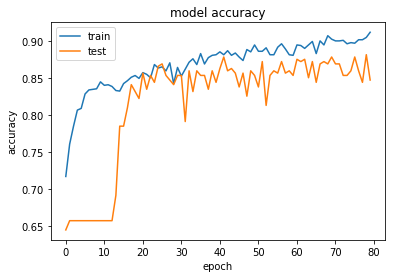

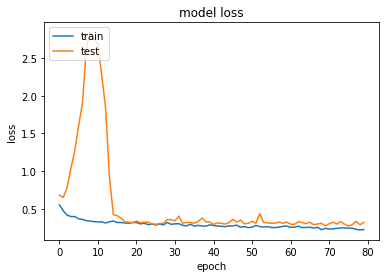

In [19]:
model.plot_results()

In [103]:
pred_test = model.predict(X_test, test)

In [111]:
# clipping
for p in pred_test:
    print(p[1])
    val = p[1]
    
    if val < 0.025:
        val = 0.025
        
    elif val > 0.975:
        val = 0.975
        
    p[1] = val
    
    print(p[1])

model.create_submission(pred_test, test)

0.0369616
0.0369616
0.196795
0.196795
0.025
0.025
0.975
0.975
0.025
0.025
0.0312446
0.0312446
0.0574131
0.0574131
0.975
0.975
0.025
0.025
0.025
0.025
0.025
0.025
0.0410375
0.0410375
0.025
0.025
0.294159
0.294159
0.025
0.025
0.025
0.025
0.025
0.025
0.0808564
0.0808564
0.0948212
0.0948212
0.975
0.975
0.025
0.025
0.751833
0.751833
0.252036
0.252036
0.0272324
0.0272324
0.025
0.025
0.025
0.025
0.566309
0.566309
0.0661362
0.0661362
0.0257904
0.0257904
0.975
0.975
0.025
0.025
0.6548
0.6548
0.025
0.025
0.025
0.025
0.936005
0.936005
0.923681
0.923681
0.0290829
0.0290829
0.025
0.025
0.025
0.025
0.886727
0.886727
0.029926
0.029926
0.0496582
0.0496582
0.025
0.025
0.025
0.025
0.177203
0.177203
0.661889
0.661889
0.975
0.975
0.348275
0.348275
0.975
0.975
0.025
0.025
0.025
0.025
0.166034
0.166034
0.975
0.975
0.0773542
0.0773542
0.123763
0.123763
0.975
0.975
0.025
0.025
0.128248
0.128248
0.025
0.025
0.025
0.025
0.025
0.025
0.0312221
0.0312221
0.975
0.975
0.296991
0.296991
0.0520963
0.0520963
0.0545643


0.118946
0.118946
0.941532
0.941532
0.13793
0.13793
0.13074
0.13074
0.919576
0.919576
0.509091
0.509091
0.975
0.975
0.025
0.025
0.0492613
0.0492613
0.025
0.025
0.313927
0.313927
0.970596
0.970596
0.224206
0.224206
0.025
0.025
0.025
0.025
0.911998
0.911998
0.0433278
0.0433278
0.801345
0.801345
0.067093
0.067093
0.485473
0.485473
0.0878854
0.0878854
0.92975
0.92975
0.623491
0.623491
0.025
0.025
0.025
0.025
0.025
0.025
0.19078
0.19078
0.025
0.025
0.040799
0.040799
0.025
0.025
0.60829
0.60829
0.975
0.975
0.025
0.025
0.025
0.025
0.0376866
0.0376866
0.975
0.975
0.133031
0.133031
0.742541
0.742541
0.025
0.025
0.0573791
0.0573791
0.573465
0.573465
0.352197
0.352197
0.025
0.025
0.0530096
0.0530096
0.025
0.025
0.96856
0.96856
0.187725
0.187725
0.131131
0.131131
0.591825
0.591825
0.281134
0.281134
0.103923
0.103923
0.0327066
0.0327066
0.025
0.025
0.113619
0.113619
0.961255
0.961255
0.937439
0.937439
0.358256
0.358256
0.025
0.025
0.025
0.025
0.025
0.025
0.975
0.975
0.559745
0.559745
0.324155
0.324

0.025
0.025
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.41374
0.41374
0.025
0.025
0.025
0.025
0.025
0.025
0.237458
0.237458
0.025
0.025
0.0798107
0.0798107
0.739859
0.739859
0.0745764
0.0745764
0.025
0.025
0.975
0.975
0.634939
0.634939
0.0561586
0.0561586
0.0355563
0.0355563
0.0693463
0.0693463
0.441577
0.441577
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.792871
0.792871
0.025
0.025
0.719304
0.719304
0.025
0.025
0.025
0.025
0.890482
0.890482
0.025
0.025
0.975
0.975
0.975
0.975
0.107179
0.107179
0.437344
0.437344
0.025
0.025
0.621837
0.621837
0.122809
0.122809
0.025
0.025
0.030401
0.030401
0.512112
0.512112
0.025
0.025
0.025
0.025
0.201564
0.201564
0.025
0.025
0.074464
0.074464
0.025
0.025
0.975
0.975
0.0962858
0.0962858
0.70757
0.70757
0.025
0.025
0.513321
0.513321
0.966946
0.966946
0.025
0.025
0.025
0.025
0.106468
0.106468
0.972049
0.972049
0.29002
0.29002
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.975
0.975
0.0518122
0.0518122
0.975
0.975
0.025
0.025
0.025
0.025
0.

0.025
0.025
0.025
0.025
0.0684632
0.0684632
0.955185
0.955185
0.975
0.975
0.025
0.025
0.0278371
0.0278371
0.0295323
0.0295323
0.025
0.025
0.0363873
0.0363873
0.542126
0.542126
0.975
0.975
0.187507
0.187507
0.025
0.025
0.704664
0.704664
0.025
0.025
0.025
0.025
0.142045
0.142045
0.975
0.975
0.0300607
0.0300607
0.171726
0.171726
0.025
0.025
0.025
0.025
0.025
0.025
0.320183
0.320183
0.863142
0.863142
0.380441
0.380441
0.025
0.025
0.0333543
0.0333543
0.025
0.025
0.946894
0.946894
0.839975
0.839975
0.025
0.025
0.357297
0.357297
0.025
0.025
0.224844
0.224844
0.975
0.975
0.025
0.025
0.11139
0.11139
0.193684
0.193684
0.0381595
0.0381595
0.279878
0.279878
0.062404
0.062404
0.751801
0.751801
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.973738
0.973738
0.084786
0.084786
0.025
0.025
0.025
0.025
0.603614
0.603614
0.950586
0.950586
0.025
0.025
0.358568
0.358568
0.025
0.025
0.964985
0.964985
0.702894
0.702894
0.025
0.025
0.025
0.025
0.025
0.025
0.190244
0.190244
0.697024
0

0.975
0.975
0.975
0.975
0.0770904
0.0770904
0.025
0.025
0.025
0.025
0.025
0.025
0.503511
0.503511
0.937978
0.937978
0.337163
0.337163
0.0597975
0.0597975
0.685398
0.685398
0.975
0.975
0.025
0.025
0.975
0.975
0.025
0.025
0.218216
0.218216
0.444544
0.444544
0.0323253
0.0323253
0.975
0.975
0.222656
0.222656
0.0361735
0.0361735
0.871895
0.871895
0.974748
0.974748
0.150898
0.150898
0.397852
0.397852
0.975
0.975
0.124952
0.124952
0.198408
0.198408
0.025
0.025
0.0814909
0.0814909
0.955749
0.955749
0.478331
0.478331
0.975
0.975
0.036044
0.036044
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.025
0.46121
0.46121
0.12385
0.12385
0.025
0.025
0.16372
0.16372
0.025
0.025
0.0449038
0.0449038
0.975
0.975
0.860858
0.860858
0.101663
0.101663
0.0664645
0.0664645
0.0355116
0.0355116
0.025
0.025
0.035743
0.035743
0.949917
0.949917
0.0510591
0.0510591
0.025
0.025
0.025
0.025
0.124609
0.124609
0.025
0.025
0.538973
0.538973
0.0363512
0.0363512
0.025
0.025
0.206855
0.206855
0.278488
0.278488
0.025
0.025
0.051896

0.251413
0.251413
0.0465
0.0465
0.975
0.975
0.025
0.025
0.025
0.025
0.0704653
0.0704653
0.025
0.025
0.0402858
0.0402858
0.460714
0.460714
0.025
0.025
0.025
0.025
0.941521
0.941521
0.975
0.975
0.705799
0.705799
0.0459692
0.0459692
0.0711934
0.0711934
0.025
0.025
0.025
0.025
0.0638216
0.0638216
0.709575
0.709575
0.331887
0.331887
0.182585
0.182585
0.025
0.025
0.975
0.975
0.473479
0.473479
0.108057
0.108057
0.025
0.025
0.930739
0.930739
0.799212
0.799212
0.025
0.025
0.0580049
0.0580049
0.025
0.025
0.88885
0.88885
0.160502
0.160502
0.121026
0.121026
0.272344
0.272344
0.135055
0.135055
0.025
0.025
0.975
0.975
0.0253756
0.0253756
0.735249
0.735249
0.0338473
0.0338473
0.975
0.975
0.025
0.025
0.025
0.025
0.131105
0.131105
0.72407
0.72407
0.255606
0.255606
0.203194
0.203194
0.232727
0.232727
0.675016
0.675016
0.025
0.025
0.025
0.025
0.025
0.025
0.227308
0.227308
0.784696
0.784696
0.025
0.025
0.025
0.025
0.025
0.025
0.276938
0.276938
0.025
0.025
0.962302
0.962302
0.905546
0.905546
0.025
0.025
0.

0.116055
0.116055
0.0372278
0.0372278
0.975
0.975
0.842792
0.842792
0.841917
0.841917
0.436151
0.436151
0.224939
0.224939
0.0670489
0.0670489
0.414836
0.414836
0.0710129
0.0710129
0.693863
0.693863
0.107211
0.107211
0.025
0.025
0.025
0.025
0.076051
0.076051
0.025
0.025
0.0741337
0.0741337
0.0951103
0.0951103
0.0627026
0.0627026
0.0594068
0.0594068
0.025
0.025
0.0759522
0.0759522
0.19677
0.19677
0.025
0.025
0.0571028
0.0571028
0.025
0.025
0.975
0.975
0.025
0.025
0.025
0.025
0.0713704
0.0713704
0.025
0.025
0.025
0.025
0.598842
0.598842
0.952286
0.952286
0.025
0.025
0.025
0.025
0.654825
0.654825
0.0328933
0.0328933
0.174101
0.174101
0.0257486
0.0257486
0.025
0.025
0.207208
0.207208
0.025
0.025
0.154007
0.154007
0.113828
0.113828
0.149014
0.149014
0.903128
0.903128
0.361058
0.361058
0.0800546
0.0800546
0.850076
0.850076
0.025
0.025
0.337046
0.337046
0.170801
0.170801
0.971791
0.971791
0.025
0.025
0.025
0.025
0.969508
0.969508
0.025
0.025
0.975
0.975
0.025
0.025
0.353653
0.353653
0.0405125


0.0513644
0.300184
0.300184
0.025
0.025
0.206176
0.206176
0.134271
0.134271
0.127896
0.127896
0.975
0.975
0.453902
0.453902
0.665471
0.665471
0.106418
0.106418
0.861346
0.861346
0.0265883
0.0265883
0.521707
0.521707
0.025
0.025
0.18946
0.18946
0.0410161
0.0410161
0.0368347
0.0368347
0.108509
0.108509
0.100823
0.100823
0.9393
0.9393
0.895268
0.895268
0.356274
0.356274
0.356992
0.356992
0.025
0.025
0.025
0.025
0.975
0.975
0.595665
0.595665
0.47533
0.47533
0.025
0.025
0.975
0.975
0.96823
0.96823
0.0389544
0.0389544
0.9003
0.9003
0.398366
0.398366
0.132556
0.132556
0.145826
0.145826
0.212657
0.212657
0.119876
0.119876
0.025
0.025
0.317515
0.317515
0.733209
0.733209
0.025
0.025
0.025
0.025
0.864617
0.864617
0.025
0.025
0.025
0.025
0.0553301
0.0553301
0.207811
0.207811
0.025
0.025
0.0733645
0.0733645
0.025
0.025
0.452914
0.452914
0.975
0.975
0.975
0.975
0.025
0.025
0.840006
0.840006
0.200725
0.200725
0.025
0.025
0.025
0.025
0.538932
0.538932
0.844441
0.844441
0.025
0.025
0.025
0.025
0.278836

0.0587279
0.025
0.025
0.975
0.975
0.025
0.025
0.0456951
0.0456951
0.69682
0.69682
0.0802122
0.0802122
0.0264434
0.0264434
0.434921
0.434921
0.025
0.025
0.0282373
0.0282373
0.975
0.975
0.025
0.025
0.216246
0.216246
0.0506829
0.0506829
0.975
0.975
0.025
0.025


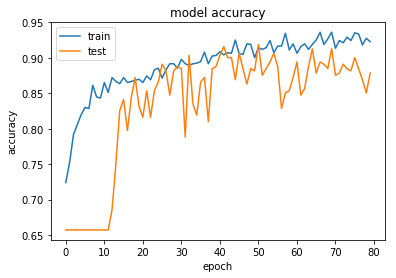

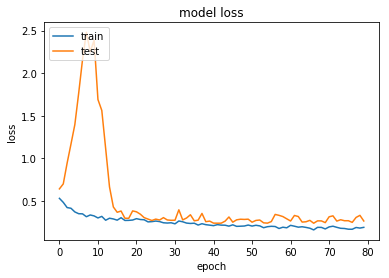

In [37]:
model.plot_results()

Model: davemodel
Batch Size: 32
Epochs: 80
Epoch 1/80
41/40 [==============================] - 2s - loss: 0.5765 - acc: 0.6737 - val_loss: 0.6837 - val_acc: 0.5670
Epoch 2/80
41/40 [==============================] - 1s - loss: 0.4909 - acc: 0.7430 - val_loss: 0.6349 - val_acc: 0.6573
Epoch 3/80
41/40 [==============================] - 1s - loss: 0.4433 - acc: 0.7682 - val_loss: 0.6643 - val_acc: 0.6573
Epoch 4/80
41/40 [==============================] - 1s - loss: 0.4224 - acc: 0.7971 - val_loss: 0.6887 - val_acc: 0.6573
Epoch 5/80
41/40 [==============================] - 1s - loss: 0.3804 - acc: 0.8159 - val_loss: 0.6811 - val_acc: 0.6573
Epoch 6/80
41/40 [==============================] - 1s - loss: 0.3792 - acc: 0.8174 - val_loss: 0.8034 - val_acc: 0.6573
Epoch 7/80
41/40 [==============================] - 1s - loss: 0.3465 - acc: 0.8437 - val_loss: 0.9113 - val_acc: 0.6573
Epoch 8/80
41/40 [==============================] - 1s - loss: 0.3302 - acc: 0.8460 - val_loss: 0.9754 - val_a

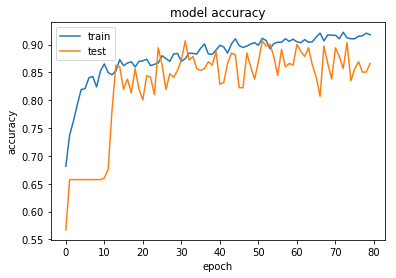

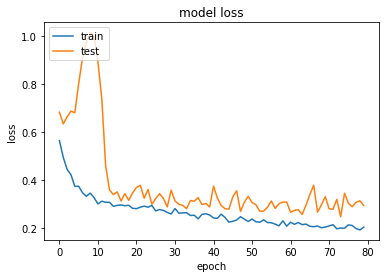

In [38]:
model = DaveModel(Xtr, ytr, Xv, yv)
model.train(32, 80)
model.plot_results()

In [14]:
from __future__ import print_function
from __future__ import absolute_import

import warnings
import numpy as np

from keras.models import Model
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Reshape

from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense

from keras.layers import Concatenate, concatenate
from keras.layers import Add, add
from keras.layers import Multiply, multiply

from keras import backend as K


class SEResNeXt(object):
    def __init__(self, size=96, num_classes=10, depth=64, reduction_ratio=4, num_split=8, num_block=3):
        self.depth = depth # number of channels
        self.ratio = reduction_ratio # ratio of channel reduction in SE module
        self.num_split = num_split # number of splitting trees for ResNeXt (so called cardinality)
        self.num_block = num_block # number of residual blocks
        if K.image_data_format() == 'channels_first':
            self.channel_axis = 1
        else:
            self.channel_axis = 3
        self.model = self.build_model(Input(shape=(size,size,3)), num_classes)

    def conv_bn(self, x, filters, kernel_size, stride, padding='same'):
        '''
        Combination of Conv and BN layers since these always appear together.
        '''
        x = Conv2D( filters=filters, kernel_size=[kernel_size, kernel_size]
                               , strides=[stride, stride], padding=padding )(x)
        x = BatchNormalization()(x)
        
        return x
    
    def activation(self, x, func='relu'):
        '''
        Activation layer.
        '''
        return Activation(func)(x)
    
    def channel_zeropad(self, x):
        '''
        Zero-padding for channle dimensions.
        Note that padded channles are added like (Batch, H, W, 2/x + x + 2/x).
        '''
        shape = list(x.shape)
        y = K.zeros_like(x)
        
        if self.channel_axis == 3:
            y = y[:, :, :, :shape[self.channel_axis]//2]
        else:
            y = y[:, :shape[self.channel_axis]//2, :, :]
        
        return concatenate([y, x, y], self.channel_axis)
    
    def channel_zeropad_output(self, input_shape):
        '''
        Function for setting a channel dimension for zero padding.
        '''
        shape = list(input_shape)
        shape[self.channel_axis] *= 2

        return tuple(shape)
    
    def initial_layer(self, inputs):
        '''
        Initial layers includes {conv, BN, relu}.
        '''
        x = self.conv_bn(inputs, self.depth, 3, 1)
        x = self.activation(x)
        
        return x
    
    def transform_layer(self, x, stride):
        '''
        Transform layer has 2 {conv, BN, relu}.
        '''
        x = self.conv_bn(x, self.depth, 1, 1)
        x = self.activation(x)
        
        x = self.conv_bn(x, self.depth, 3, stride)
        x = self.activation(x)
        
        return x
        
    def split_layer(self, x, stride):
        '''
        Parallel operation of transform layers for ResNeXt structure.
        '''
        splitted_branches = list()
        for i in range(self.num_split):
            branch = self.transform_layer(x, stride)
            splitted_branches.append(branch)
        
        return concatenate(splitted_branches, axis=self.channel_axis)
    
    def squeeze_excitation_layer(self, x, out_dim):
        '''
        SE module performs inter-channel weighting.
        '''
        squeeze = GlobalAveragePooling2D()(x)
        
        excitation = Dense(units=out_dim // self.ratio)(squeeze)
        excitation = self.activation(excitation)
        excitation = Dense(units=out_dim)(excitation)
        excitation = self.activation(excitation, 'sigmoid')
        excitation = Reshape((1,1,out_dim))(excitation)
        
        scale = multiply([x,excitation])
        
        return scale
    
    def residual_layer(self, x, out_dim):
        '''
        Residual block.
        '''
        for i in range(self.num_block):
            input_dim = int(np.shape(x)[-1])
            
            if input_dim*2 == out_dim:
                flag = True
                stride = 2
                channel = input_dim // 2
            else:
                flag = False
                stride = 1
            
            subway_x = self.split_layer(x, stride)
            subway_x = self.conv_bn(subway_x, out_dim, 1, 1)
            subway_x = self.squeeze_excitation_layer(subway_x, out_dim)
            
            if flag:
                pad_x = AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
                pad_x = Lambda(self.channel_zeropad, output_shape=self.channel_zeropad_output)(pad_x)
            else:
                pad_x = x
            
            x = self.activation(add([pad_x, subway_x]))
                
        return x
    
    def build_model(self, inputs, num_classes):
        '''
        Build a SENet model.
        '''
        x = self.initial_layer(inputs)
        
        x = self.residual_layer(x, out_dim=64)
        x = self.residual_layer(x, out_dim=128)
        x = self.residual_layer(x, out_dim=256)
        
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=num_classes, activation='softmax')(x)
        
        return Model(inputs, x)

In [15]:
class SEResNeXtModel(DaveBaseModel):
    def get_model(self):
        model = SEResNeXt(75, 2)
        
        '''Create the FCN and return a keras model.'''

#         model = Sequential()

#         # Input image: 75x75x3
#         model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
#         DaveModel.ConvBlock(model, 1, 32)
#         # 37x37x32
#         DaveModel.ConvBlock(model, 1, 64)
#         # 18x18x64
#         DaveModel.ConvBlock(model, 1, 128)
#         # 9x9x128
#         DaveModel.ConvBlock(model, 1, 128)
#         # 4x4x128
#         model.add(ZeroPadding2D((1, 1)))
#         model.add(Conv2D(2, (3, 3), activation='relu'))
#         model.add(GlobalAveragePooling2D())
#         # 4x4x2
#         model.add(Activation('softmax'))
        
        model.model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
        return model.model
    
    def get_name(self):
        return "seresnext"

In [16]:
model = SEResNeXtModel(Xtr, ytr, Xv, yv)

In [ ]:
model.train(16, 20)

In [20]:
from keras.engine import Layer, InputSpec
try:
    from keras import initializations
except ImportError:
    from keras import initializers as initializations
import keras.backend as K

class Scale(Layer):
    '''Custom Layer for DenseNet used for BatchNormalization.
    
    Learns a set of weights and biases used for scaling the input data.
    the output consists simply in an element-wise multiplication of the input
    and a sum of a set of constants:

        out = in * gamma + beta,

    where 'gamma' and 'beta' are the weights and biases larned.

    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).
        momentum: momentum in the computation of the
            exponential average of the mean and standard deviation
            of the data, for feature-wise normalization.
        weights: Initialization weights.
            List of 2 Numpy arrays, with shapes:
            `[(input_shape,), (input_shape,)]`
        beta_init: name of initialization function for shift parameter
            (see [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        gamma_init: name of initialization function for scale parameter (see
            [initializations](../initializations.md)), or alternatively,
            Theano/TensorFlow function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
    '''
    def __init__(self, weights=None, axis=-1, momentum = 0.9, beta_init='zero', gamma_init='one', **kwargs):
        self.momentum = momentum
        self.axis = axis
        self.beta_init = initializations.get(beta_init)
        self.gamma_init = initializations.get(gamma_init)
        self.initial_weights = weights
        super(Scale, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (int(input_shape[self.axis]),)

        # Tensorflow >= 1.0.0 compatibility
        self.gamma = K.variable(self.gamma_init(shape), name='{}_gamma'.format(self.name))
        self.beta = K.variable(self.beta_init(shape), name='{}_beta'.format(self.name))
        #self.gamma = self.gamma_init(shape, name='{}_gamma'.format(self.name))
        #self.beta = self.beta_init(shape, name='{}_beta'.format(self.name))
        self.trainable_weights = [self.gamma, self.beta]

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights

    def call(self, x, mask=None):
        input_shape = self.input_spec[0].shape
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis]

        out = K.reshape(self.gamma, broadcast_shape) * x + K.reshape(self.beta, broadcast_shape)
        return out

    def get_config(self):
        config = {"momentum": self.momentum, "axis": self.axis}
        base_config = super(Scale, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


from keras.models import Model
from keras.layers import Input, merge, ZeroPadding2D
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.backend as K


def DenseNet(nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.0, dropout_rate=0.0, weight_decay=1e-4, classes=1000, weights_path=None):
    '''Instantiate the DenseNet 121 architecture,
        # Arguments
            nb_dense_block: number of dense blocks to add to end
            growth_rate: number of filters to add per dense block
            nb_filter: initial number of filters
            reduction: reduction factor of transition blocks.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            classes: optional number of classes to classify images
            weights_path: path to pre-trained weights
        # Returns
            A Keras model instance.
    '''
    eps = 1.1e-5

    # compute compression factor
    compression = 1.0 - reduction

    # Handle Dimension Ordering for different backends
    global concat_axis
    if K.image_dim_ordering() == 'tf':
      concat_axis = 3
      img_input = Input(shape=(75, 75, 3), name='data')
    else:
      concat_axis = 1
      img_input = Input(shape=(3, 75, 75), name='data')

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6,12,24,16] # For DenseNet-121

    # Initial convolution
    x = ZeroPadding2D((3, 3), name='conv1_zeropadding')(img_input)
    x = Convolution2D(nb_filter, 7, 7, subsample=(2, 2), name='conv1', bias=False)(x)
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv1_bn')(x)
    x = Scale(axis=concat_axis, name='conv1_scale')(x)
    x = Activation('relu', name='relu1')(x)
    x = ZeroPadding2D((1, 1), name='pool1_zeropadding')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), name='pool1')(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx+2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

        # Add transition_block
        x = transition_block(x, stage, nb_filter, compression=compression, dropout_rate=dropout_rate, weight_decay=weight_decay)
        nb_filter = int(nb_filter * compression)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate, weight_decay=weight_decay)

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name='conv'+str(final_stage)+'_blk_bn')(x)
    x = Scale(axis=concat_axis, name='conv'+str(final_stage)+'_blk_scale')(x)
    x = Activation('relu', name='relu'+str(final_stage)+'_blk')(x)
    x = GlobalAveragePooling2D(name='pool'+str(final_stage))(x)

    x = Dense(classes, name='fc6')(x)
    x = Activation('softmax', name='prob')(x)

    model = Model(img_input, x, name='densenet')

    if weights_path is not None:
      model.load_weights(weights_path)

    return model


def conv_block(x, stage, branch, nb_filter, dropout_rate=None, weight_decay=1e-4):
    '''Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and option dropout
        # Arguments
            x: input tensor 
            stage: index for dense block
            branch: layer index within each dense block
            nb_filter: number of filters
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''
    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_' + str(branch)
    relu_name_base = 'relu' + str(stage) + '_' + str(branch)

    # 1x1 Convolution (Bottleneck layer)
    inter_channel = nb_filter * 4  
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x1_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x1_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x1')(x)
    x = Convolution2D(inter_channel, 1, 1, name=conv_name_base+'_x1', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    # 3x3 Convolution
    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_x2_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_x2_scale')(x)
    x = Activation('relu', name=relu_name_base+'_x2')(x)
    x = ZeroPadding2D((1, 1), name=conv_name_base+'_x2_zeropadding')(x)
    x = Convolution2D(nb_filter, 3, 3, name=conv_name_base+'_x2', bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x


def transition_block(x, stage, nb_filter, compression=1.0, dropout_rate=None, weight_decay=1E-4):
    ''' Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout 
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_filter: number of filters
            compression: calculated as 1 - reduction. Reduces the number of feature maps in the transition block.
            dropout_rate: dropout rate
            weight_decay: weight decay factor
    '''

    eps = 1.1e-5
    conv_name_base = 'conv' + str(stage) + '_blk'
    relu_name_base = 'relu' + str(stage) + '_blk'
    pool_name_base = 'pool' + str(stage) 

    x = BatchNormalization(epsilon=eps, axis=concat_axis, name=conv_name_base+'_bn')(x)
    x = Scale(axis=concat_axis, name=conv_name_base+'_scale')(x)
    x = Activation('relu', name=relu_name_base)(x)
    x = Convolution2D(int(nb_filter * compression), 1, 1, name=conv_name_base, bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2), name=pool_name_base)(x)

    return x


def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, weight_decay=1e-4, grow_nb_filters=True):
    ''' Build a dense_block where the output of each conv_block is fed to subsequent ones
        # Arguments
            x: input tensor
            stage: index for dense block
            nb_layers: the number of layers of conv_block to append to the model.
            nb_filter: number of filters
            growth_rate: growth rate
            dropout_rate: dropout rate
            weight_decay: weight decay factor
            grow_nb_filters: flag to decide to allow number of filters to grow
    '''

    eps = 1.1e-5
    concat_feat = x

    for i in range(nb_layers):
        branch = i+1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate, weight_decay)
        concat_feat = merge([concat_feat, x], mode='concat', concat_axis=concat_axis, name='concat_'+str(stage)+'_'+str(branch))

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


In [21]:
densemodel = DenseNet(classes = 2)

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), use_bias=False, name="conv1", strides=(2, 2))`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv2_1_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv2_1_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:238: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is de

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_1_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_2_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_2_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_3_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_22_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_23_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_23_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_24_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=F

In [22]:
densemodel.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
data (InputLayer)                (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2D (None, 81, 81, 3)     0           data[0][0]                       
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 38, 38, 64)    9408        conv1_zeropadding[0][0]          
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 38, 38, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

____________________________________________________________________________________________________
conv5_8_x1_bn (BatchNormalizatio (None, 2, 2, 1632)    6528        concat_5_7[0][0]                 
____________________________________________________________________________________________________
conv5_8_x1_scale (Scale)         (None, 2, 2, 1632)    3264        conv5_8_x1_bn[0][0]              
____________________________________________________________________________________________________
relu5_8_x1 (Activation)          (None, 2, 2, 1632)    0           conv5_8_x1_scale[0][0]           
____________________________________________________________________________________________________
conv5_8_x1 (Conv2D)              (None, 2, 2, 128)     208896      relu5_8_x1[0][0]                 
____________________________________________________________________________________________________
conv5_8_x2_bn (BatchNormalizatio (None, 2, 2, 128)     512         conv5_8_x1[0][0]        

In [25]:
class DenseNetModel(DaveBaseModel):
    def get_model(self):
        model = DenseNet(classes = 2)
        '''Create the FCN and return a keras model.'''

#         model = Sequential()

#         # Input image: 75x75x3
#         model.add(Lambda(lambda x: x, input_shape=(75, 75, 3)))
#         DaveModel.ConvBlock(model, 1, 32)
#         # 37x37x32
#         DaveModel.ConvBlock(model, 1, 64)
#         # 18x18x64
#         DaveModel.ConvBlock(model, 1, 128)
#         # 9x9x128
#         DaveModel.ConvBlock(model, 1, 128)
#         # 4x4x128
#         model.add(ZeroPadding2D((1, 1)))
#         model.add(Conv2D(2, (3, 3), activation='relu'))
#         model.add(GlobalAveragePooling2D())
#         # 4x4x2
#         model.add(Activation('softmax'))
        
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
        return model
    
    def get_name(self):
        return "densenet"

In [26]:
model = DenseNetModel(Xtr, ytr, Xv, yv)

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:118: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (7, 7), use_bias=False, name="conv1", strides=(2, 2))`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv2_1_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv2_1_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:238: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is de

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:209: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(640, (1, 1), use_bias=False, name="conv3_blk")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_1_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_1_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_2_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False

C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_21_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_22_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, name="conv4_22_x2")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:172: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (1, 1), use_bias=False, name="conv4_23_x1")`
C:\Users\Dave\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:182: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=F

In [29]:
model.train(16, 10)

Model: densenet
Batch Size: 16
Epochs: 10
Epoch 1/10
81/80 [==============================] - 20s - loss: 0.2359 - acc: 0.8979 - val_loss: 0.3820 - val_acc: 0.8255
Epoch 2/10
81/80 [==============================] - 19s - loss: 0.2159 - acc: 0.9157 - val_loss: 0.3154 - val_acc: 0.8723
Epoch 3/10
81/80 [==============================] - 20s - loss: 0.2274 - acc: 0.9072 - val_loss: 0.3738 - val_acc: 0.8660
Epoch 4/10
81/80 [==============================] - 19s - loss: 0.2318 - acc: 0.8989 - val_loss: 0.3210 - val_acc: 0.8816
Epoch 5/10
81/80 [==============================] - 20s - loss: 0.2277 - acc: 0.9033 - val_loss: 0.4518 - val_acc: 0.8100
Epoch 6/10
81/80 [==============================] - 19s - loss: 0.2243 - acc: 0.9005 - val_loss: 0.3413 - val_acc: 0.8536
Epoch 7/10
81/80 [==============================] - 19s - loss: 0.2342 - acc: 0.9049 - val_loss: 0.3443 - val_acc: 0.8785
Epoch 8/10
81/80 [==============================] - 19s - loss: 0.2348 - acc: 0.9043 - val_loss: 0.4795 

https://github.com/BIGBALLON/cifar-10-cnn

In [51]:
import keras
from keras import optimizers
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard

batch_size    = 128
epochs        = 200
iterations    = 391
num_classes   = 2
log_filepath  = './lenet'

def build_model():
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(75,75,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(2, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.SGD(lr=.01, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def scheduler(epoch):
    if epoch <= 60:
        return 0.05
    if epoch <= 120:
        return 0.01
    if epoch <= 160:    
        return 0.002
    return 0.0004

# if __name__ == '__main__':

#     # load data
#     (x_train, y_train), (x_test, y_test) = cifar10.load_data()
#     y_train = keras.utils.to_categorical(y_train, num_classes)
#     y_test = keras.utils.to_categorical(y_test, num_classes)
#     x_train = x_train.astype('float32')
#     x_test = x_test.astype('float32')
#     x_train /= 255
#     x_test /= 255

    # build network
#     model = build_model()
#     print(model.summary())
#     # set callback
#     tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
#     change_lr = LearningRateScheduler(scheduler)
#     cbks = [change_lr,tb_cb]

#     # start traing 
#     model.fit(x_train, y_train,batch_size=batch_size,epochs=epochs,callbacks=cbks,
#                   validation_data=(x_test, y_test), shuffle=True)
#     # save model
#     model.save('lenet.h5')

In [52]:
class LeNetModel2(DaveBaseModel):
    def get_model(self):
        return build_model()
    
    def get_name(self):
        return "lenet2"

In [53]:
model = LeNetModel2(Xtr, ytr, Xv, yv)

In [56]:
model.train(32, 50)

Model: lenet2
Batch Size: 32
Epochs: 50
Epoch 1/50
41/40 [==============================] - 3s - loss: 0.3607 - acc: 0.8175 - val_loss: 0.4849 - val_acc: 0.7445
Epoch 2/50
41/40 [==============================] - 2s - loss: 0.3550 - acc: 0.8238 - val_loss: 0.3708 - val_acc: 0.8069
Epoch 3/50
41/40 [==============================] - 3s - loss: 0.2921 - acc: 0.8548 - val_loss: 0.3378 - val_acc: 0.8318
Epoch 4/50
41/40 [==============================] - 2s - loss: 0.3002 - acc: 0.8604 - val_loss: 0.3845 - val_acc: 0.7850
Epoch 5/50
41/40 [==============================] - 2s - loss: 0.3030 - acc: 0.8449 - val_loss: 0.3382 - val_acc: 0.8380
Epoch 6/50
41/40 [==============================] - 2s - loss: 0.3115 - acc: 0.8403 - val_loss: 0.3408 - val_acc: 0.8318
Epoch 7/50
41/40 [==============================] - 2s - loss: 0.3050 - acc: 0.8566 - val_loss: 0.3398 - val_acc: 0.8505
Epoch 8/50
41/40 [==============================] - 2s - loss: 0.2882 - acc: 0.8555 - val_loss: 0.3448 - val_acc:

In [94]:
from keras.initializers import he_normal
from keras import regularizers

weight_decay       = 0.0005

def color_preprocessing(x_train,x_test):
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    mean = [125.307, 122.95, 113.865]
    std  = [62.9932, 62.0887, 66.7048]
    for i in range(3):
        x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
        x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]

    return x_train, x_test

def wide_residual_network(img_input,classes_num,depth,k):

    print('Wide-Resnet %dx%d' %(depth, k))
    n_filters  = [16, 16*k, 32*k, 64*k]
    n_stack    = (depth - 4) / 6
    in_filters = 16

    def conv3x3(x,filters):
    	return Conv2D(filters=filters, kernel_size=(3,3), strides=(1,1), padding='same',
    	kernel_initializer=he_normal(),
        kernel_regularizer=regularizers.l2(weight_decay))(x)

    def residual_block(x,out_filters,increase_filter=False):
        if increase_filter:
            first_stride = (2,2)
        else:
            first_stride = (1,1)
        pre_bn   = BatchNormalization()(x)
        pre_relu = Activation('relu')(pre_bn)
        conv_1 = Conv2D(out_filters,kernel_size=(3,3),strides=first_stride,padding='same',kernel_initializer=he_normal(),kernel_regularizer=regularizers.l2(weight_decay))(pre_relu)
        bn_1   = BatchNormalization()(conv_1)
        relu1  = Activation('relu')(bn_1)
        conv_2 = Conv2D(out_filters, kernel_size=(3,3), strides=(1,1), padding='same', kernel_initializer=he_normal(),kernel_regularizer=regularizers.l2(weight_decay))(relu1)
        if increase_filter or in_filters != out_filters:
            projection = Conv2D(out_filters,kernel_size=(1,1),strides=first_stride,padding='same',kernel_initializer=he_normal(),kernel_regularizer=regularizers.l2(weight_decay))(x)
            block = add([conv_2, projection])
        else:
            block = add([conv_2,x])
        return block

    def wide_residual_layer(x,out_filters,increase_filter=False):
    	x = residual_block(x,out_filters,increase_filter)
    	in_filters = out_filters
    	for _ in range(1,int(n_stack)):
    		x = residual_block(x,out_filters)
    	return x


    x = conv3x3(img_input,n_filters[0])
    x = wide_residual_layer(x,n_filters[1])
    x = wide_residual_layer(x,n_filters[2],increase_filter=True)
    x = wide_residual_layer(x,n_filters[3],increase_filter=True)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes_num,activation='softmax',kernel_initializer=he_normal(),kernel_regularizer=regularizers.l2(weight_decay))(x)


    return x

In [95]:
class WideResidualModel(DaveBaseModel):
    depth              = 16
    wide               = 8
    num_classes        = 2
    img_rows, img_cols = 75, 75
    img_channels       = 3
    batch_size         = 128
    epochs             = 200
    iterations         = 391
    log_filepath       = r'./w_resnet/'
    
    def get_model(self):
        img_input = Input(shape=(self.img_rows,self.img_cols,self.img_channels))
        output = wide_residual_network(img_input,self.num_classes,self.depth,self.wide)
        resnet = Model(img_input, output)
        print(resnet.summary())
        # set optimizer
        resnet.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
#         sgd = optimizers.SGD(lr=.01, momentum=0.9, nesterov=True)
#         resnet.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
        return resnet
    
    def get_name(self):
        return "wide"

In [96]:
Xtr2, Xv2 = color_preprocessing(Xtr, Xv)

In [97]:
model = WideResidualModel(Xtr2, ytr, Xv2, yv)

Wide-Resnet 16x8
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv2d_490 (Conv2D)              (None, 75, 75, 16)    448         input_15[0][0]                   
____________________________________________________________________________________________________
batch_normalization_436 (BatchNo (None, 75, 75, 16)    64          conv2d_490[0][0]                 
____________________________________________________________________________________________________
activation_474 (Activation)      (None, 75, 75, 16)    0           batch_normalization_436[0][0]    
__________________________________________________________________________

In [103]:
model.train(32, 20)

Model: wide
Batch Size: 32
Epochs: 20
Epoch 1/20
41/40 [==============================] - 26s - loss: 1.9431 - acc: 0.7514 - val_loss: 2.0569 - val_acc: 0.6573
Epoch 2/20
41/40 [==============================] - 26s - loss: 1.9056 - acc: 0.7564 - val_loss: 2.7941 - val_acc: 0.6573
Epoch 3/20
41/40 [==============================] - 26s - loss: 1.8394 - acc: 0.7788 - val_loss: 3.7357 - val_acc: 0.6573
Epoch 4/20
41/40 [==============================] - 26s - loss: 1.7993 - acc: 0.7567 - val_loss: 4.6903 - val_acc: 0.6573
Epoch 5/20
25/40 [=================>............] - ETA: 9s - loss: 1.7423 - acc: 0.7788

KeyboardInterrupt: 

In [101]:
model.predict(X_test, test)

array([[  9.99999642e-01,   3.94188163e-07],
       [  9.99999285e-01,   7.67450786e-07],
       [  9.99995112e-01,   4.87961142e-06],
       ..., 
       [  9.99999404e-01,   5.75652166e-07],
       [  9.99999523e-01,   4.57558031e-07],
       [  9.99994874e-01,   5.11484541e-06]], dtype=float32)